In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

# **data**

In [3]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-10-01 14:45:51--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.03s   

2025-10-01 14:45:52 (32.0 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [4]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [5]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [6]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [7]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [8]:
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [9]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [10]:
block_size = 5
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1


In [11]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 32])
tensor([[58, 53,  1, 41, 53, 56, 56, 59, 54, 58,  1, 39,  1, 51, 39, 52,  5, 57,
          1, 61, 47, 44, 43,  1, 47, 57,  0, 61, 46, 43, 52,  1],
        [49,  1, 39, 52,  1, 53, 39, 58, 46,  1, 40, 63,  1, 20, 47, 51,  6,  0,
         32, 46, 43,  1, 59, 52, 47, 58, 63,  1, 58, 46, 43,  1],
        [59, 50, 42,  1, 58, 46, 53, 59,  1, 61, 43, 56, 58,  1, 57, 53,  1, 58,
         53, 53,  2,  0,  0, 24, 33, 15, 21, 27, 10,  0, 35, 43],
        [ 8,  0,  0, 35, 13, 30, 35, 21, 15, 23, 10,  0, 28, 56, 53, 60, 43,  1,
         47, 58,  6,  1, 20, 43, 52, 56, 63,  6,  1, 39, 52, 42]])
targets:
torch.Size([4, 32])
tensor([[53,  1, 41, 53, 56, 56, 59, 54, 58,  1, 39,  1, 51, 39, 52,  5, 57,  1,
         61, 47, 44, 43,  1, 47, 57,  0, 61, 46, 43, 52,  1, 57],
        [ 1, 39, 52,  1, 53, 39, 58, 46,  1, 40, 63,  1, 20, 47, 51,  6,  0, 32,
         46, 43,  1, 59, 52, 47, 58, 63,  1, 58, 46, 43,  1, 49],
        [50, 42,  1, 58, 46, 53, 59,  1, 61, 43, 56, 58,  1,

# **code**

In [12]:
device_name = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)

print(f">>> {device_name.upper()} IS BEING USED")

>>> CUDA IS BEING USED


In [144]:
class config:
  d_model: int = 256
  hidden_states: int = 1024
  n_experts: int = 6
  top_k_experts: int = 3
  n_shared_experts: int = 2

  n_heads: int = 8

  n_decoder_block: int = 8
  n_groups: int = 4
  vocab_size: int = 65
  max_len: int = 180
  max_input_length: int = 500

config = config()

In [145]:
class Embedding(nn.Module):

  def __init__(self, config):
      super().__init__()
      self.embeddings = nn.Embedding(config.vocab_size, config.d_model)

  def forward(self, x):
      B,T = x.shape
      x = self.embeddings(x)   # B, T, C
      return x

In [146]:
class RoPE(nn.Module):

  def __init__(self):
      super().__init__()

  def angle(self, T, x):
      device = x.device
      B, H, T, D = x.shape
      power = torch.arange(0, D, 2, dtype=torch.float32, device=device)/D
      inv_freq = 10000 ** (-power)
      pos = torch.arange(0, T, device = device).unsqueeze(1)
      angle = pos * inv_freq
      return angle    # [T, D/2]


  def forward(self, x):
      device = x.device
      B, H, T, D = x.shape

      angles = self.angle(T, x)                     # [T, D/2]

      cos = angles.cos().unsqueeze(0).unsqueeze(0)  # [1, 1, T, D/2]

      sin = angles.sin().unsqueeze(0).unsqueeze(0)  # [1, 1, T, D/2]

      x_even = x[..., ::2]                          # [B, H, T, D/2]
      x_odd  = x[..., 1::2]                         # [B, H, T, D/2]

      rot_even = cos * x_even - sin * x_odd
      rot_odd  = sin * x_even + cos * x_odd

      return torch.stack([rot_even, rot_odd], dim = -1).flatten(-2)

In [ ]:
mat1 and mat2 shapes cannot be multiplied (4x256 and 1024x256)

In [265]:
class SiLu(nn.Module):

  def __init__(self, config):
      super().__init__()

  def forward(self, x):
      return x * torch.sigmoid(x)

In [266]:
class Expert(nn.Module):

  def __init__(self, config=config):
    super().__init__()
    self.layer1 = nn.Linear(config.d_model, config.hidden_states)
    self.silu = SiLu(config)
    self.layer2 = nn.Linear(config.hidden_states, config.d_model)


  def forward(self, x):
    x = self.layer1(x)    # [ B, T, 1024]
    x = self.silu(x)
    x = self.layer2(x)
    return x

#----------------------------------------------------------------------------------#

class SharedExpert(nn.Module):

  def __init__(self, config=config):
    super().__init__()
    self.layer1 = nn.Linear(config.d_model, config.hidden_states)
    self.silu = SiLu(config)
    self.layer2 = nn.Linear(config.hidden_states, config.d_model)


  def forward(self, x):
    x = self.layer1(x)
    x = self.silu(x)
    x = self.layer2(x)
    return x

In [267]:
class MoEs(nn.Module):

  def __init__(self, config = config):
    super().__init__()
    self.top_k = config.top_k_experts
    #self.tokens = config.tokens
    self.n_experts = config.n_experts
    self.n_shared_experts = config.n_shared_experts
    self.d_model = config.d_model
    self.load_coef = 0.01
    self.router = nn.Linear(config.d_model, config.n_experts)  # [B, T, n_experts]
    self.all_experts = nn.ModuleList([Expert() for _ in range(self.n_experts)])
    self.shared_experts = nn.ModuleList([SharedExpert() for _ in range(self.n_shared_experts)])

  def norm_expert_weights(self, x):
    weights, indices = x.topk(self.top_k, dim = -1)
    normalised_weights = F.softmax(weights, dim = -1)
    all_zeros = torch.zeros(x.size(), device = device)
    norm_weights = all_zeros.scatter(-1, indices, normalised_weights)
    norm_weights, indices = norm_weights.reshape(-1, norm_weights.size(-1)), indices.reshape(-1, indices.size(-1))
    return norm_weights, indices

  def fi(self, x):
    " x is all the tokens weightage with respect to experts  [B*T, n_experts]"
    x = x > 0  # converts all the number to booleans.  [B*T , n_experts]

    zeros = torch.zeros(x.size(), device = device)
    all_zeros = zeros > 0

    f = (x==all_zeros)
    f = f.int()
    f = 1 - f # swapping 1 and 0s

    f = torch.tensor(f, device = device, dtype = torch.float16)

    return f.mean(dim = -2)

  def forward(self, x):

    B, T, C = x.size()
    flatten_inputs = x.reshape(-1, C)
    expert_weights = self.router(x)
    expert_weights, expert_index = self.norm_expert_weights(expert_weights)
    #print(expert_weights, '\n', expert_index)

    #-------------------SHARED EXPERTS---------------------------------------------#

    shared_experts_output = torch.zeros(flatten_inputs.size(), device = device)  # initializing to zero
    if self.n_shared_experts > 0:

      for e in range(self.n_shared_experts):
        i_expert_output = self.shared_experts[e](flatten_inputs)
        shared_experts_output = shared_experts_output + i_expert_output   # [B*T, C]

    #-------------------ROUTED EXPERTS---------------------------------------------#

    after_expert_outputs = torch.zeros(flatten_inputs.size(), device= device)  # tokens after expert-matrices are stored here.

    for exp_id, expert in enumerate(self.all_experts):  #goes for E1, E2 and E3.
      mask = (expert_index == exp_id)
      masked = mask.any(dim = -1)

      if masked.sum() == 0:
        continue

      token_idx = torch.nonzero(masked).squeeze(-1)

      particular_token = flatten_inputs[token_idx]
      experts_output = expert(particular_token)

      #print(expert_weights)
      weights = expert_weights[token_idx, exp_id]
      #print(weights.unsqueeze(-1))
      experts_output = experts_output * weights.unsqueeze(-1)      # [N, C] * [N, 1]  = [N, C]
      #print(experts_output)

      after_expert_outputs[token_idx] = after_expert_outputs[token_idx] + experts_output

    #------------------------------------------------------------------------------#

    total_output= after_expert_outputs + shared_experts_output

    pi = expert_weights.mean(dim = -2)  # [n_experts]
    fi = self.fi(expert_weights)        # [n_experts]

    load_balancing_loss = self.load_coef * self.n_experts * torch.sum(pi * fi)

    total_output = total_output.view(B, T, C)  # previously we reshaped from [B, T, C] to --> [B*T, C]

    return load_balancing_loss, total_output

In [268]:
moes = MoEs()

In [269]:
x_cuda = torch.rand(1, 4, 512).to(device)

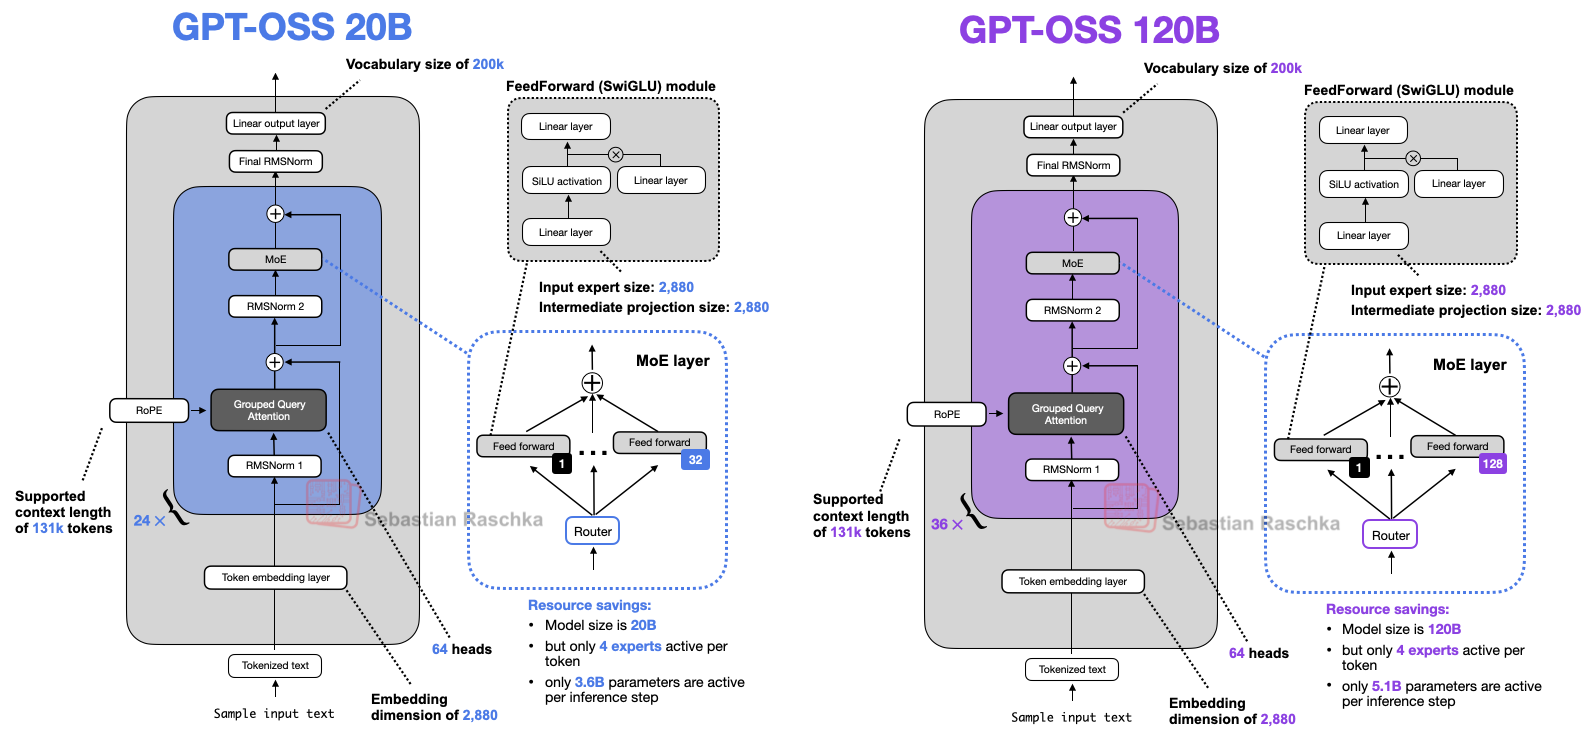

1. register Buffer

In [270]:
class GroupedQueryAttention(nn.Module):

  def __init__(self, config):
    super().__init__()

    assert config.d_model % config.n_heads == 0, "embedding dimension should be divisible by number of heads"

    self.n_heads = config.n_heads
    self.d_head = config.d_model // config.n_heads
    self.n_groups = config.n_groups

    self.q_mat = nn.Linear(config.d_model, config.d_model)
    self.k_mat = nn.Linear(config.d_model, self.n_groups * self.d_head)
    self.v_mat = nn.Linear(config.d_model, self.n_groups * self.d_head)
    self.output = nn.Linear(config.d_model, config.d_model)

    self.RoPE = RoPE()

    self.k_cache = None
    self.v_cache = None

  def forward(self, x, kv_cache):
    B, T, C = x.size()
    device = x.device

    query = self.q_mat(x)               # [ B, T, C]
    key = self.k_mat(x)                 # [ B, T, n_groups * d_model]
    value = self.v_mat(x)               # [ B, T, n_groups * d_model]

    nquery = query.view(B, T, self.n_heads, self.d_head).transpose(1, 2)
    gkey   = key.view(B, T, self.n_groups, self.d_head).transpose(1, 2)                 # [ B, n_groups, T,  d_head]
    gvalue = value.view(B, T, self.n_groups, self.d_head).transpose(1, 2)

    nquery = self.RoPE(nquery)
    gkey = self.RoPE(gkey)

    indices = torch.arange(0, self.n_heads, device=device) // (self.n_heads // self.n_groups)
    indices = indices.to(device)

    if kv_cache:
      if self.k_cache == None:
        self.k_cache = gkey
        self.v_cache = gvalue
      else:
        self.k_cache = torch.concat([self.k_cache, gkey], dim = 2)
        self.v_cache = torch.concat([self.v_cache, gvalue], dim = 2)

      gkey = self.k_cache
      gvalue = self.v_cache

    nkey = gkey[:, indices, :, :]
    nvalue = gvalue[:, indices, :, :]

    attn_score = nquery @ nkey.transpose(-2, -1) * (1. / math.sqrt(nkey.size(-1)))

    all_zeros = torch.triu(torch.ones(T, T, device = x.device), diagonal = 1)
    casual_mask = all_zeros.masked_fill(all_zeros == 1, value = float('-inf'))
    attn_score = attn_score + casual_mask
    attn_score = F.softmax(attn_score, dim = -1)

    attn = attn_score @ nvalue
    after_attn = attn.transpose(1,2).contiguous().view(B, T, -1)  # bringing back to 512 dimension
    after_attn = self.output(after_attn)

    # print(after_attn.size()) # Removed print statement
    return after_attn # Added return statement

In [271]:
class RMSNorm(nn.Module):

  def __init__(self, config, eps = 1e-9):

      super().__init__()
      self.eps = eps
      self.beta = nn.Parameter(torch.ones(config.d_model))

  def forward(self, x):
      # Ensure beta is on the same device as x
      RMS_x = torch.sqrt(torch.mean(x ** 2, dim = -1, keepdim=True) + self.eps)  # keepdim= True else the dimension w'ont match and throws error.
      x = x / RMS_x
      x = x * self.beta
      return x

In [272]:
rms = RMSNorm(config)
rms(torch.rand(1, 4, 256))

tensor([[[0.0397, 0.5123, 0.7287,  ..., 1.6731, 1.5206, 0.7815],
         [1.0665, 0.3037, 1.6056,  ..., 0.4837, 0.2938, 1.1080],
         [0.6688, 1.3581, 0.9376,  ..., 0.8419, 0.8608, 0.2021],
         [0.9139, 1.2059, 0.8446,  ..., 1.3986, 1.4264, 0.7664]]],
       grad_fn=<MulBackward0>)

In [273]:
class DecoderBlock(nn.Module):

  def __init__(self, config):

    super().__init__()
    self.rms_norm1 = RMSNorm(config)
    self.gqa = GroupedQueryAttention(config)
    self.rms_norm2 = RMSNorm(config)
    self.moe = MoEs()


  def forward(self, x, kv_cache = False):

    res = x
    x = self.rms_norm1(x)
    x = self.gqa(x, kv_cache)
    x = x + res

    res = x
    x = self.rms_norm2(x)
    loss, after_moe = self.moe(x)

    return res + after_moe, loss

In [280]:
dec = DecoderBlock(config).to(device)

dec(torch.rand(1, 4, config.d_model).to(device))[0].size()

/tmp/ipython-input-2301078117.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f = torch.tensor(f, device = device, dtype = torch.float16)


torch.Size([1, 4, 256])

In [281]:
class gptoss(nn.Module):

  def __init__(self, config):

      super().__init__()

      self.config = config
      self.embeddings = Embedding(config)
      self.decoder_stack = nn.ModuleList([DecoderBlock(config) for _ in range(config.n_decoder_block)])
      self.final_rms = RMSNorm(config)
      self.output_projection = nn.Linear(config.d_model, config.vocab_size)


  def forward(self, x, target = None, kv_cache = False):

    x = self.embeddings(x)
    BTC = x.size()

    total_moe_loss = 0
    for layer in self.decoder_stack:
      x, layer_moe_loss = layer(x, kv_cache = kv_cache)
      total_moe_loss += layer_moe_loss

    assert x.size()== BTC, "yaa mis match vayo"

    x = self.final_rms(x)
    logits = self.output_projection(x)        # logits # [ B, T, VOCAB_SIZE]
    loss = None

    if target != None:
      loss = F.cross_entropy(logits.view(-1, logits.size(-1)) , target.view(-1))

    # Add total_moe_loss to the final loss if target is not None
    if loss != None:
        loss += total_moe_loss
    else:
        # If target is None, return logits and total_moe_loss
        return logits, total_moe_loss


    return logits, loss


  @torch.no_grad()
  def predict(self, ids, max_token: int, kv_cache = True):

    B, T = ids.shape    # [B, T]  --> [[1, 5, 9 4, 6, 3,...]]   # T  = 5

    if T > self.config.max_input_length:
      ids = ids[:, :self.config.max_input_length]

     # reset cache
      for block in self.decoder_stack:
          # Assuming each decoder block has a multi_query_attention attribute
          # You might need to adjust this based on your actual implementation
          if hasattr(block, 'gqa') and hasattr(block.gqa, 'k_cache'):
              block.gqa.k_cache = None
              block.gqa.v_cache = None


      all_logits, _ = self(ids, kv_cache = kv_cache)        # [1, T, VOCAB_SIZE]
      last_logit = all_logits[:, -1, :]
      normalised_logits = F.softmax(last_logit, dim = -1)
      next_token_index = torch.multinomial(normalised_logits, 1)
      ids = torch.cat([ids, next_token_index], dim = 1)

    for _ in range(max_token):

      all_logits, _ = self(ids[:, -1:], kv_cache = kv_cache)        # [1, T, VOCAB_SIZE]
      last_logit = all_logits[:, -1, :]
      normalised_logits = F.softmax(last_logit, dim = -1)
      next_token_index = torch.multinomial(normalised_logits, 1)
      ids = torch.cat([ids, next_token_index], dim = 1)


    return ids

In [282]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [283]:
class training_configs:
  lr = 1e-4
  max_iterations = 2500

training_config = training_configs()

In [284]:
model = gptoss(config)
model = model.to(device)

In [285]:
print(f'Total Paramters are -==> {sum(p.numel() for p in model.parameters())/1e6 :.2f} millions')

Total Paramters are -==> 35.27 millions


In [286]:
def init_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)

    elif isinstance(module, nn.Embedding):
        nn.init.normal_(module.weight, mean=0.0, std=0.02)

model = model.apply(init_weights)

In [287]:
def estimate_loss(model, inference_max_itrs = 200):

  train_loss = []
  val_loss = []
  model.eval()

  for split in ["train", "val_data"]:
    for k in range(inference_max_itrs):
      X, y = get_batch(split)
      X, y = X.to(device), y.to(device)
      logits, loss = model(X, y)

      if split == "train":
        train_loss.append(loss.item())
      else:
        val_loss.append(loss.item())

  model.train()
  train_avg_loss = sum(train_loss)/len(train_loss)
  val_avg_loss = sum(val_loss)/len(val_loss)

  return train_avg_loss, val_avg_loss

In [288]:
import torch
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
from torch.cuda.amp import GradScaler, autocast

# --- Optimizer with weight decay ---
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=training_config.lr,
    betas=(0.9, 0.98),
    weight_decay=0.01,
    eps=1e-9
)

# --- Learning rate scheduler: warmup + cosine decay ---
warmup_steps = 1000
max_iters = training_configs.max_iterations
min_lr = 1e-5

scheduler_warmup = LinearLR(optimizer, start_factor=0.1, total_iters=warmup_steps)
scheduler_decay = CosineAnnealingLR(optimizer, T_max=max_iters-warmup_steps, eta_min=min_lr)
scheduler = SequentialLR(
    optimizer,
    schedulers=[scheduler_warmup, scheduler_decay],
    milestones=[warmup_steps]
)

In [289]:
# --- Mixed precision ---
scaler = GradScaler(enabled=torch.cuda.is_available())

training_losses_ = []
val_losses = []
steps = []
epoch_step = 400

print(f"{'='*15} TRAINING LOSS INFO {'='*15}")
for epoch in range(training_configs.max_iterations):
    model.train()
    X, y = get_batch("train")
    # Move tensors to the correct device before autocast
    X, y = X.to(device), y.to(device)


    optimizer.zero_grad()

    # Use autocast for mixed precision
    with torch.amp.autocast('cuda', dtype=torch.float16 if torch.cuda.is_available() else torch.float32):
      logits, loss = model(X, y)


    # Scale loss for mixed precision
    scaler.scale(loss).backward()

    # Gradient clipping for stability
    scaler.unscale_(optimizer)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    scaler.step(optimizer)
    scaler.update()

    # Step scheduler
    scheduler.step()

    if epoch % epoch_step == 0:
        train_loss, val_loss = estimate_loss(model)
        training_losses_.append(train_loss)
        val_losses.append(val_loss)
        steps.append(epoch+1)

        print(f"{'='*15} STEP: {epoch+1}/{training_configs.max_iterations} {'='*15}")
        print(f"Training Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}\n")

print(f"{'='*42}")
print("\nTRAINING SUMMARY")
print(f"{'-'*len('TRAINING SUMMARY')}")

dropped_percentage = (training_losses_[0] - training_losses_[-1]) / training_losses_[0] * 100
print(f"Loss Dropped Percentage: {dropped_percentage:.2f}%")

/tmp/ipython-input-856460772.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())
/tmp/ipython-input-2301078117.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f = torch.tensor(f, device = device, dtype = torch.float16)


=============== TRAINING LOSS INFO ===============
=============== STEP: 1/2500 ===============
Training Loss: 5.2406 | Val Loss: 5.2372
Current LR: 0.000010

=============== STEP: 401/2500 ===============
Training Loss: 2.8373 | Val Loss: 2.8711
Current LR: 0.000046

=============== STEP: 801/2500 ===============
Training Loss: 2.6114 | Val Loss: 2.6222
Current LR: 0.000082



/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


=============== STEP: 1201/2500 ===============
Training Loss: 2.3910 | Val Loss: 2.4451
Current LR: 0.000096

=============== STEP: 1601/2500 ===============
Training Loss: 2.2557 | Val Loss: 2.3090
Current LR: 0.000069

=============== STEP: 2001/2500 ===============
Training Loss: 2.1534 | Val Loss: 2.2393
Current LR: 0.000032

=============== STEP: 2401/2500 ===============
Training Loss: 2.1257 | Val Loss: 2.2068
Current LR: 0.000011


TRAINING SUMMARY
----------------
Loss Dropped Percentage: 59.44%


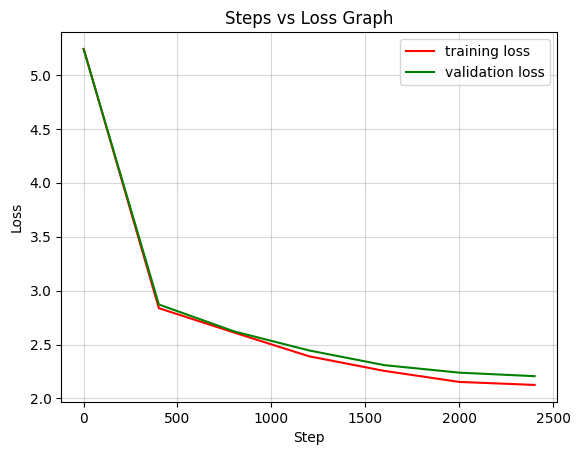

In [298]:
import matplotlib.pyplot as plt

plt.title("Steps vs Loss Graph")
plt.xlabel("Step")
plt.ylabel("Loss")

plt.plot(steps, training_losses_, color = "red", label = 'training loss')
plt.plot(steps, val_losses, color = "green", label = 'validation loss')
plt.grid(True, alpha=0.5)
plt.legend()
plt.show()

In [299]:
model = model.to(device)

In [300]:
ids = encode("citizens, th")
ids = torch.tensor(ids).unsqueeze(0).to(device)
ids

tensor([[41, 47, 58, 47, 64, 43, 52, 57,  6,  1, 58, 46]], device='cuda:0')